# Evaluacion de los modelos

## lectura de los csv por numero de intento

In [1]:
#%%
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour
from time import time
import pickle
import os
from dotenv import load_dotenv
import urllib


In [2]:

st = "mysql+mysqldb://{u}:{p}@{ip}:3306/optuna_rf_db".format(p=urllib.parse.quote_plus(os.getenv("password")), u = os.getenv("usersrv"), ip = os.getenv("ip"))

study = optuna.load_study(
    study_name= "experimento_sampling_10perc",
    storage= st)

top_5 = study.trials_dataframe().sort_values("value", ascending = False).head(5).number.values

In [3]:
top_5 = ["-" + str(i) + "-" for i in top_5]
top_5

['-17-', '-15-', '-16-', '-27-', '-22-']

In [4]:

def read_files_as_dataframes(directory_path, ids=None, file_extension='.csv'):
    dataframes = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
      if filename.endswith(file_extension):
        if any([True for x in ids if x in filename]):
            file_path = os.path.join(directory_path, filename)
            # Read the file as a Pandas DataFrame
            df = pd.read_csv(file_path)
            df.rename(columns={'public_cum':'public_score_acumulado',
                               'private_cum':'private_score_acumulado'}, inplace=True)
            df['model'] = filename.replace('df_cut_point-lgbm_binaria_t3', '')
            df['trial'] = df['model'].str.extract(r'-([0-9]+)-')
            df['semilla'] = df['model'].str.extract(r'-([0-9]+)\.csv')
            dataframes.append(df)
    
    return dataframes



In [5]:
directory_path = '../testing'

dataframes = read_files_as_dataframes(directory_path, top_5)




In [6]:
def plot_scores(dataframe, trial):
    plt.figure(figsize=(10, 6))
    for i in dataframe['semilla'].unique():
        df_semilla = dataframe[dataframe['semilla'] == i]
        plt.plot(df_semilla['nro_envios'], df_semilla['public_score_acumulado'], label=f'Public {i}')
        plt.plot(df_semilla['nro_envios'], df_semilla['private_score_acumulado'], label=f'Private {i}')
    
    plt.title(f'Public and Private Scores {trial}')
    plt.xlabel('Envios')
    plt.ylabel('Scores')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [7]:
# bind all dataframes together
dataframes_concat = pd.concat(dataframes)
dataframes_concat['trial'].unique()

ValueError: No objects to concatenate

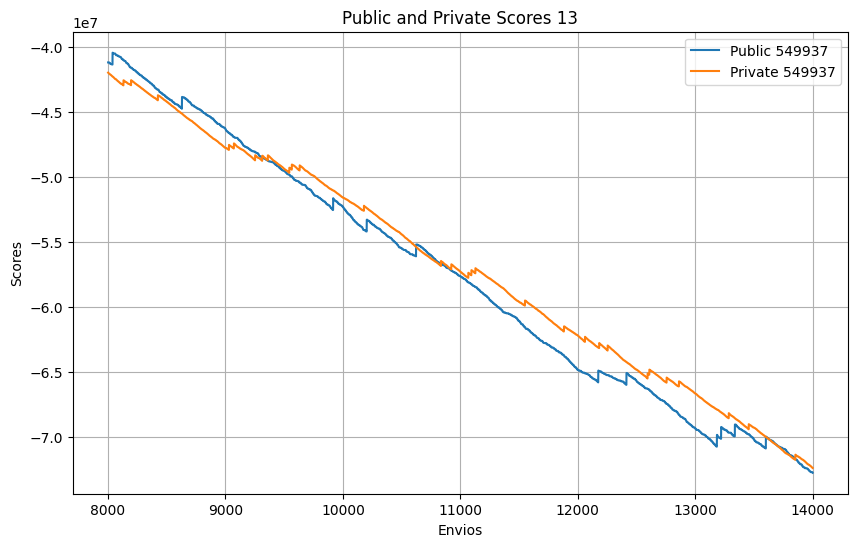

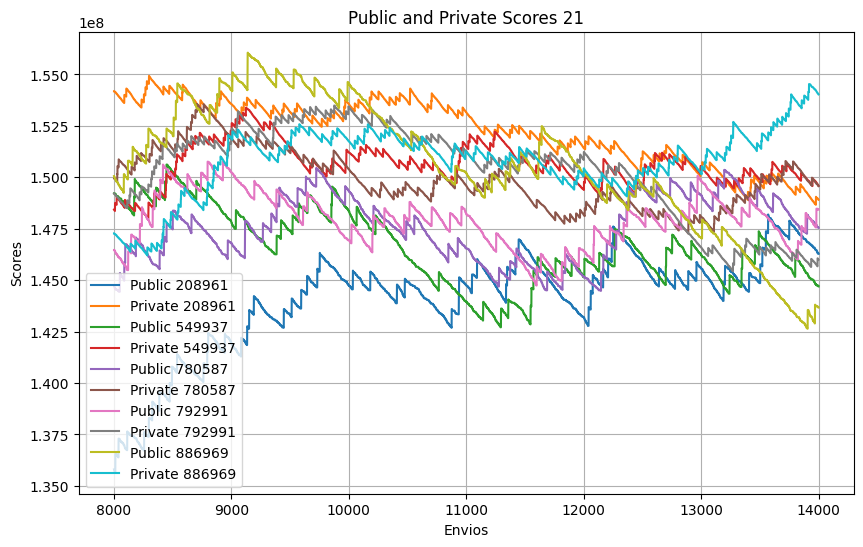

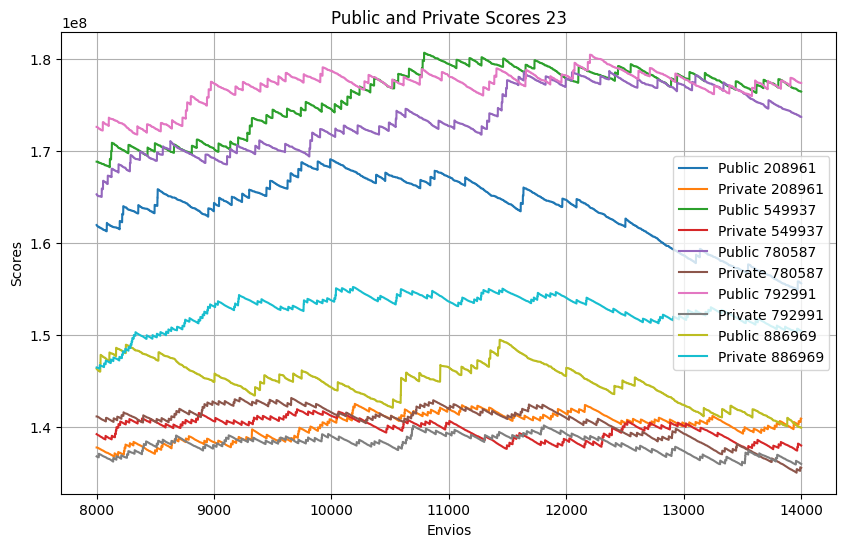

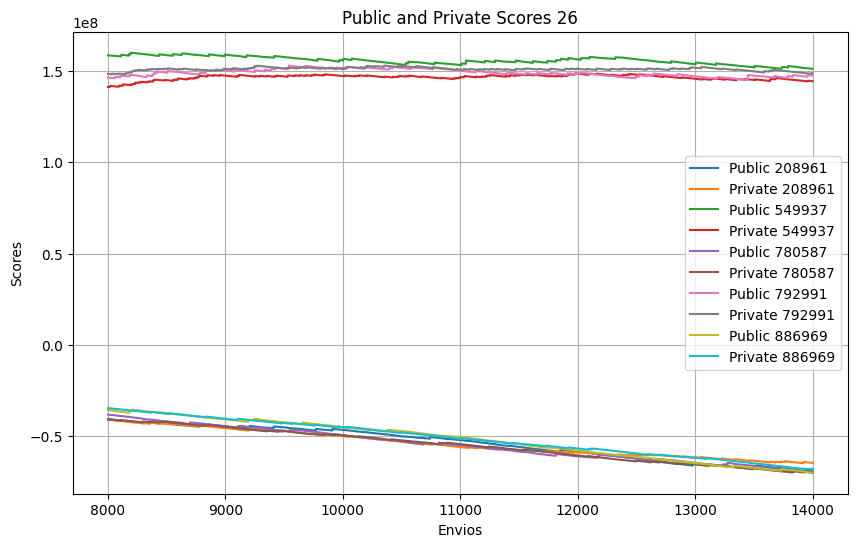

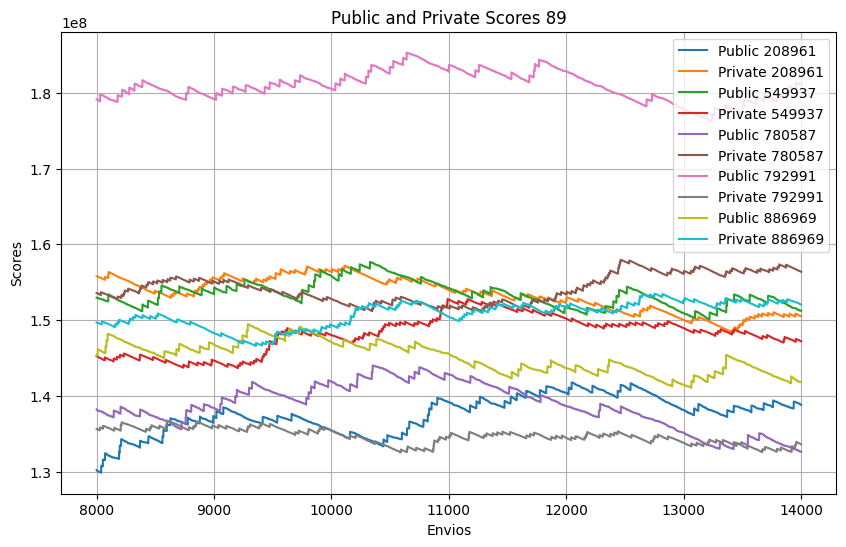

In [41]:
for i in dataframes_concat['trial'].unique():
    df = dataframes_concat[(dataframes_concat['trial'] == i) & (dataframes_concat['nro_envios'] > 8000) & (dataframes_concat['nro_envios'] < 14000)]
    plot_scores(df, i)

In [35]:
def plot_scores_mean(dataframe, trial):
    plt.figure(figsize=(10, 6))
    plt.plot(dataframe['nro_envios'], dataframe['public_score_acumulado'], label=f'Public {i}')
    plt.plot(dataframe['nro_envios'], dataframe['private_score_acumulado'], label=f'Private {i}')
    
    plt.title(f'Public and Private Scores {trial}')
    plt.xlabel('Envios')
    plt.ylabel('Scores')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

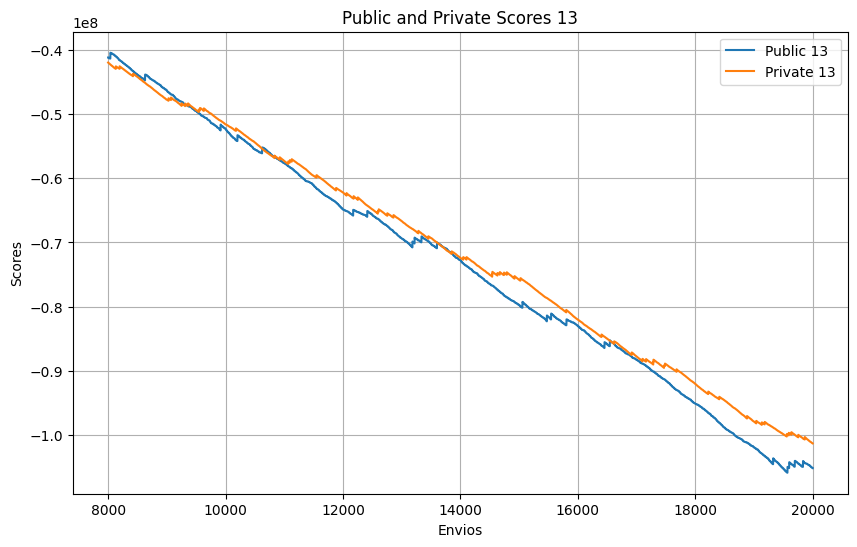

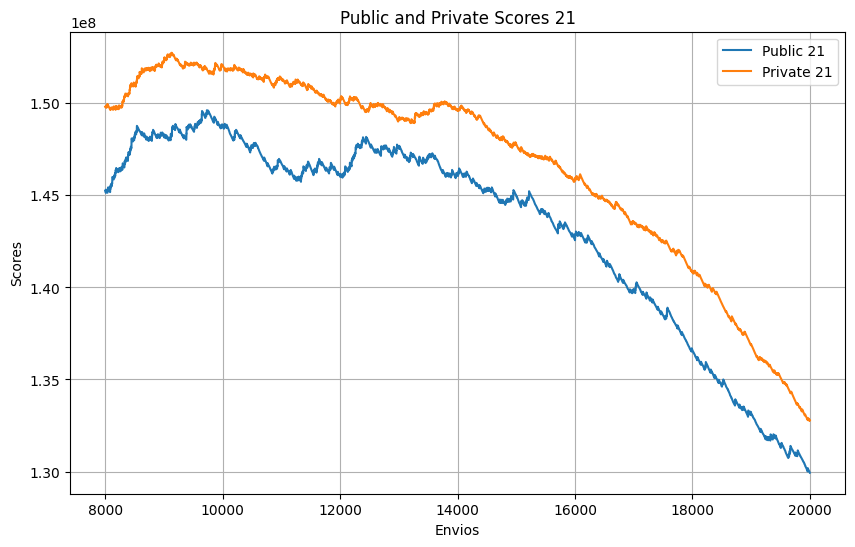

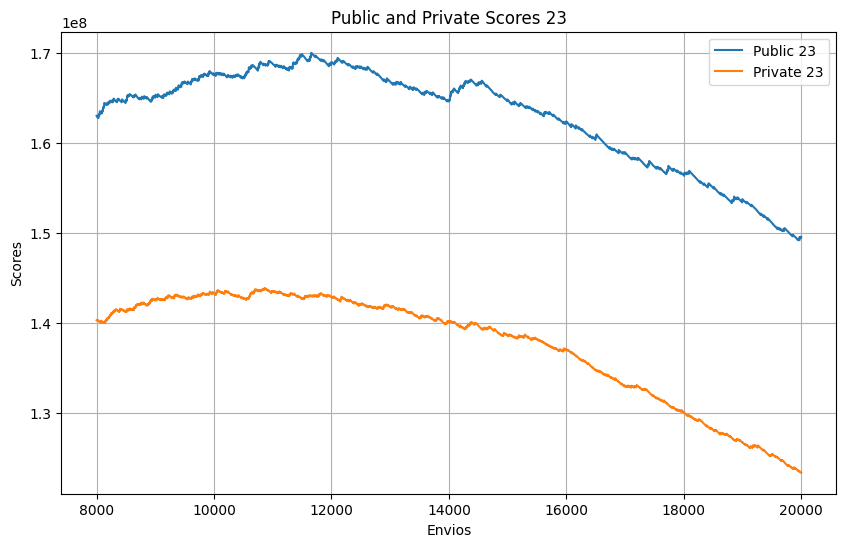

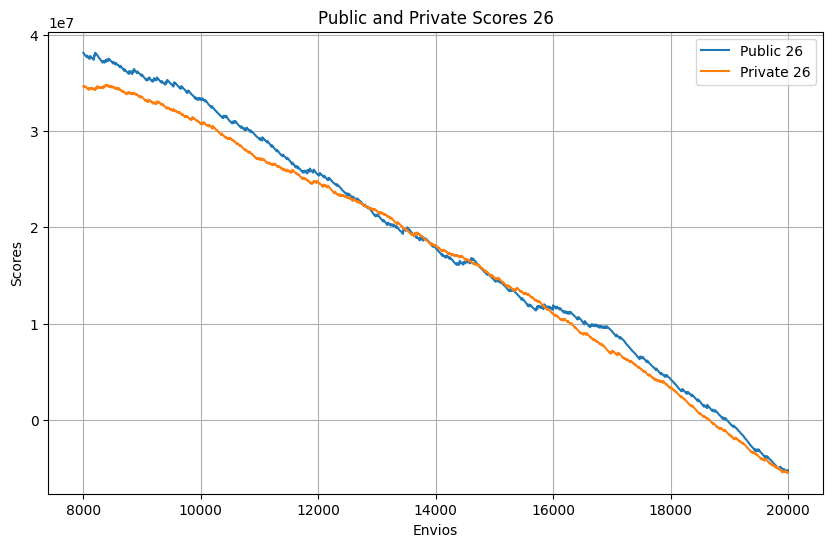

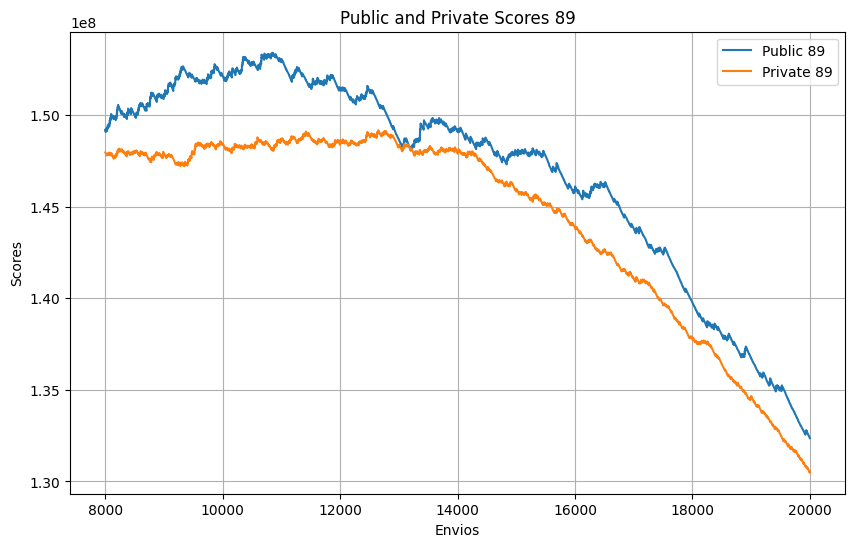

In [43]:
for i in dataframes_concat['trial'].unique():
    df = dataframes_concat[(dataframes_concat['trial'] == i) & (dataframes_concat['nro_envios'] > 8000) & (dataframes_concat['nro_envios'] < 20000)]
    # calculate the mean of public and private scores, excluding non-numeric columns
    df_mean = df.groupby('nro_envios').mean(numeric_only=True).reset_index()
    plot_scores_mean(df_mean, i)